In [ ]:
import numpy as np
import pandas as pd


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK resources
nltk.download('punkt')

# Load the first Excel file (news-pal.xlsx)
url_pal = "https://github.com/rosenfa/ai/blob/master/news-pal.xlsx?raw=true"
df_pal = pd.read_excel(url_pal)

# Load the second Excel file (news-israel.xlsx)
url_israel = "https://github.com/rosenfa/ai/blob/master/news-israel.xlsx?raw=true"
df_israel = pd.read_excel(url_israel)

df_israel.dropna(inplace=True)
df_pal.dropna(inplace=True)


# Add a 'target' column to both dataframes
df_pal['target'] = False  # Assuming 'false' for news-pal.xlsx
df_israel['target'] = True   # Assuming 'true' for news-israel.xlsx


# Concatenate the two dataframes
df_combined = pd.concat([df_pal, df_israel], ignore_index=True)
df_combined.dropna(inplace=True)

# Tokenize the documents
#tokenized_documents = [word_tokenize(doc) for doc in df_combined['Content'].dropna()]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
print(df_pal.size)
print(df_israel.size)
print(df_combined.size)

950
950
1900


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

df_combined['Content'] = df_combined['Content'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df_combined

,Content,target
0,": Qatar , mediator Gaza truce talks , confirme...",False
1,Hamas says holds US President Joe Biden admini...,False
2,Israeli attacks besieged Gaza Strip amount toœ...,False
3,Israeli warplanes artillery bomb several areas...,False
4,`` Israel respects international laws conventi...,False
...,...,...
945,"White nationalists , usually anti-Muslim bigot...",True
946,"Israel agreed hostage deal , Hamas may intend ...",True
947,"rise campus antisemitism around world , Techni...",True
948,WZO offers mobile showers IDF soldiers heart G...,True


In [ ]:
# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(df_combined))
train_samples = df_combined[:-num_validation_samples]
training_sentences = train_samples['Content'].values.astype(str)  # Convert to NumPy array and ensure string type
labels = df_combined['target']

In [ ]:
val_samples = df_combined[-num_validation_samples:]
testing_sentences  = val_samples['Content'].values.astype(str)  # Convert to NumPy array and ensure string type
training_labels = labels[:-num_validation_samples]
testing_labels = labels[-num_validation_samples:]

In [ ]:
training_sentences[0]

': Qatar , mediator Gaza truce talks , confirmed humanitarian pause agreed .'

In [ ]:
#85%
# # Vocabulary size of the tokenizer
# vocab_size = 15000

# # Maximum length of the padded sequences
# max_length = 32

# # # Output dimensions of the Embedding layer
# embedding_dim = 32

vocab_size = 500

# Maximum length of the padded sequences
max_length = 32

# Output dimensions of the Embedding layer
embedding_dim = 32

In [ ]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Parameters for padding and OOV tokens
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

In [ ]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')

shape of sample_array = (1, 3, 2)
sample array: [[[10  2]
  [ 1  3]
  [ 1  1]]]
output shape of gap1d_layer: (1, 2)
output array of gap1d_layer: [[4 2]]


In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 32)            16000     
                                                                 
 flatten_2 (Flatten)         (None, 1024)              0         
                                                                 
 dense_8 (Dense)             (None, 24)                24600     
                                                                 
 dense_9 (Dense)             (None, 1)                 25        
                                                                 
Total params: 40625 (158.69 KB)
Trainable params: 40625 (158.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
24/24 - 1s - loss: 0.6395 - accuracy: 0.6118 - val_loss: 0.9647 - val_accuracy: 0.0842 - 1s/epoch - 43ms/step
Epoch 2/30
24/24 - 0s - loss: 0.5586 - accuracy: 0.7368 - val_loss: 0.7082 - val_accuracy: 0.6947 - 97ms/epoch - 4ms/step
Epoch 3/30
24/24 - 0s - loss: 0.4549 - accuracy: 0.8145 - val_loss: 0.4976 - val_accuracy: 0.8211 - 103ms/epoch - 4ms/step
Epoch 4/30
24/24 - 0s - loss: 0.3047 - accuracy: 0.9066 - val_loss: 0.5014 - val_accuracy: 0.7737 - 84ms/epoch - 3ms/step
Epoch 5/30
24/24 - 0s - loss: 0.1882 - accuracy: 0.9421 - val_loss: 0.3723 - val_accuracy: 0.8474 - 101ms/epoch - 4ms/step
Epoch 6/30
24/24 - 0s - loss: 0.1146 - accuracy: 0.9711 - val_loss: 0.2986 - val_accuracy: 0.8947 - 83ms/epoch - 3ms/step
Epoch 7/30
24/24 - 0s - loss: 0.0772 - accuracy: 0.9829 - val_loss: 0.3775 - val_accuracy: 0.8263 - 99ms/epoch - 4ms/step
Epoch 8/30
24/24 - 0s - loss: 0.0560 - accuracy: 0.9895 - val_loss: 0.2775 - val_accuracy: 0.8947 - 102ms/epoch - 4ms/step
Epoch 9/30
24/24 - 0s 

In [ ]:
# Build model2
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Print the model summary
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 32, 32)            16000     
                                                                 
 global_average_pooling1d_5  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 24)                792       
                                                                 
 dense_11 (Dense)            (None, 1)                 25        
                                                                 
Total params: 16817 (65.69 KB)
Trainable params: 16817 (65.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now with the simple flatten:

In [ ]:
# Compile the model
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
num_epochs = 29

# Train the model
history = model2.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/29
24/24 - 1s - loss: 0.6820 - accuracy: 0.6250 - val_loss: 0.7283 - val_accuracy: 0.0158 - 1s/epoch - 44ms/step
Epoch 2/29
24/24 - 0s - loss: 0.6546 - accuracy: 0.6461 - val_loss: 0.7619 - val_accuracy: 0.0684 - 77ms/epoch - 3ms/step
Epoch 3/29
24/24 - 0s - loss: 0.6161 - accuracy: 0.6763 - val_loss: 0.7745 - val_accuracy: 0.1737 - 81ms/epoch - 3ms/step
Epoch 4/29
24/24 - 0s - loss: 0.5631 - accuracy: 0.7566 - val_loss: 0.7617 - val_accuracy: 0.3947 - 84ms/epoch - 4ms/step
Epoch 5/29
24/24 - 0s - loss: 0.5010 - accuracy: 0.8197 - val_loss: 0.6778 - val_accuracy: 0.5947 - 97ms/epoch - 4ms/step
Epoch 6/29
24/24 - 0s - loss: 0.4382 - accuracy: 0.8513 - val_loss: 0.6032 - val_accuracy: 0.7105 - 100ms/epoch - 4ms/step
Epoch 7/29
24/24 - 0s - loss: 0.3783 - accuracy: 0.8803 - val_loss: 0.5140 - val_accuracy: 0.7789 - 90ms/epoch - 4ms/step
Epoch 8/29
24/24 - 0s - loss: 0.3230 - accuracy: 0.9053 - val_loss: 0.4664 - val_accuracy: 0.7842 - 114ms/epoch - 5ms/step
Epoch 9/29
24/24 - 0s -

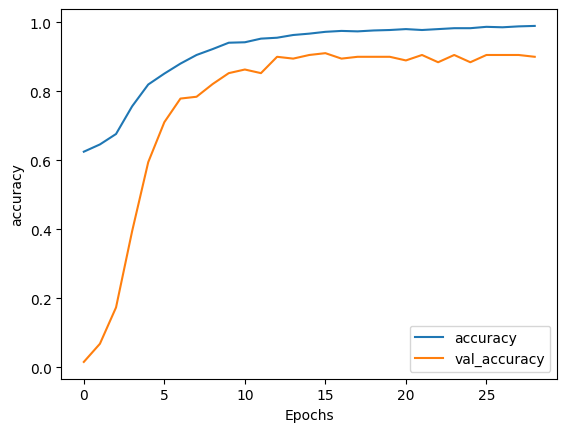

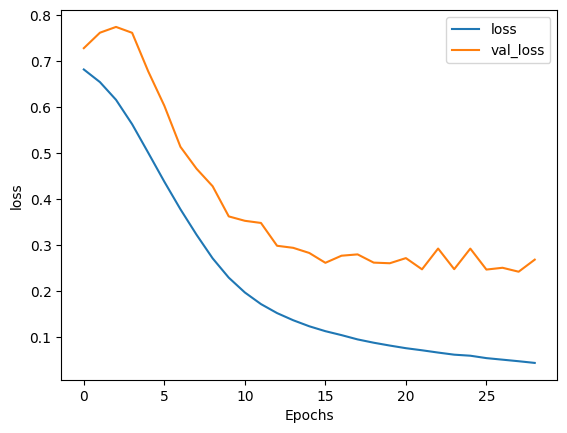

In [ ]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape)

(500, 32)
